### Student: Giulio Cesare Mastrocinque Santo

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---

### Imports

In [10]:
import cv2     
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt                          

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


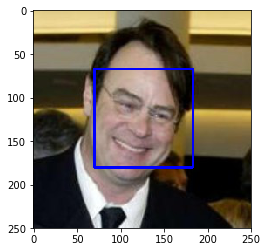

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
def face_detector(img_path):
    """
    This function returns True if the provided
    image contains a human face and else otherwise.
    
    Arguments:
        img_path: a path to an image
    
    Output:
        True/False
    """
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

The cascate classifier was able to detect 98% of human faces in the first 100 images in the human_files and 17% of human faces in the first 100 images of the dog_files.

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

percentage_humans = np.mean(list(map(face_detector,human_files_short)))
percentage_dogs = np.mean(list(map(face_detector,dog_files_short)))

print(f"Percentage of Human Faces Detected in human_files: {percentage_humans}")
print(f"Percentage of Human Faces Detected in dog_files: {percentage_dogs}")

Percentage of Human Faces Detected in human_files: 0.98
Percentage of Human Faces Detected in dog_files: 0.17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 88015180.26it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
def image_transformations(training=False):
    """
    This function defines torchvision transformations
    for both the training and validation scenarions. 
    For the training case, data augmentation is performed
    with random rotation and horizontal flip.
    
    Arguments:
        training: whether the transformations are for a
        training data or not
    
    Output:
        transformations: torchvision Compose object
    """
    
    if training:
        transformations = transforms.Compose([
                              transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.RandomRotation(30),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], 
                                                   [0.229, 0.224, 0.225])
                            ])
    else:
        transformations = transforms.Compose([
                              transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], 
                                                   [0.229, 0.224, 0.225])
                            ])        
    
    return transformations

def image_preprocessing(img_path, transformations):
    ''' 
    This function loads an image and apply to it 
    the provided transformations.
    
    Arguments:
        img_path: the image path to be loaded
        transformations: torchvision transforms object
    
    Output:
        image: a Pytorch tensor
    '''
    
    #Load Image
    image = Image.open(img_path)
    
    #Apply Transformations
    image = transformations(image).unsqueeze_(0)
    
    return image

def VGG16_predict(img_path, VGG16, use_cuda):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Arguments:
        img_path: path to an image
        VGG16: the trained vgg16 classifier
        use_cuda: whether or not to use cuda
        
    Output:
        Index corresponding to VGG-16 model's prediction
    '''
    #Preprocess Image
    transformations = image_transformations()
    image = image_preprocessing(img_path, transformations)
    
    #Make Prediction
    if use_cuda:
        VGG16 = VGG16.cuda()
        image = image.cuda()
        
    VGG16.eval()
    
    with torch.no_grad():
        pred = VGG16.forward(image)
    
    softmax = torch.nn.Softmax(dim=1)
    pred = softmax(pred)
    
    top_p, top_class = pred.topk(1, dim=1)
    
    return top_class.cpu()

In [15]:
VGG16_predict(human_files[0], VGG16, use_cuda)

tensor([[ 906]])

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
def dog_detector(img_path, VGG16, use_cuda):
    """
    This function receive and image path and
    detects if the image contains a dog in it.
    
    Arguments:
        img_path: the path to an image
        VGG16: the vgg16 trained classifier
        use_cuda: whether or not to use cuda
    
    Output:
        True/False
    """
    
    top_class = VGG16_predict(img_path, VGG16, use_cuda)
    if top_class.numpy()[0][0] in list(range(151, 269)):
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [17]:
dog_percent_in_humans = np.mean(list(map(lambda im: dog_detector(img_path=im, VGG16=VGG16, use_cuda=use_cuda), 
                                     human_files_short)))

dog_percent_in_dogs = np.mean(list(map(lambda im: dog_detector(img_path=im, VGG16=VGG16, use_cuda=use_cuda), 
                                     dog_files_short)))

print(f"Percentage of Dogs Detected in human_files: {dog_percent_in_humans}")
print(f"Percentage of Dogs Detected in dog_files: {dog_percent_in_dogs}")

Percentage of Dogs Detected in human_files: 0.0
Percentage of Dogs Detected in dog_files: 1.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [18]:
def load_train_test_valid_data(data_dir, training_transformations, validation_transformations):
    """
    This function loads training, testing and validation datasets
    according to the provided global data_dir. Then, the provided
    transformations are applied to each dataset and the resulting
    DataLoaders are returned.
    
    Arguments:
        data_dir: global directory of the images.
        transformations: torchvision transformations
        
    Returns:
        trainloader: data for training
        validloader: data for validation
        testloader: data for testing
    """
    
    #Make Directories
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    
    #Load Datasets
    train_data = datasets.ImageFolder(data_dir + '/train', transform=training_transformations)
    valid_data = datasets.ImageFolder(data_dir + '/valid', transform=validation_transformations)
    test_data = datasets.ImageFolder(data_dir + '/test', transform=validation_transformations)

    #Create DataLoaders
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
    
    loaders = {'train':trainloader,
               'valid':validloader,
               'test':testloader}
    
    return loaders

In [19]:
loaders_scratch = load_train_test_valid_data(data_dir='/data/dog_images', 
                                             training_transformations=image_transformations(training=True), 
                                             validation_transformations=image_transformations(training=False))

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

**About the Images Size**: If we look at the raw images available, the human images are RGB images with 250 X 250 dimension, while the dog images are also RGB but with 648 by 800 dimension. When building a Neural Network, all images must be of the same size. Furthermore, if transfer learning is used, the images adopted must match the original images size. For this reason, in this notebook, the images are first resized to a squared image of 250 x 250, matching the lower images (human images) size. Notice that this procedure is done with torchvision Resize function. Therefore, for images bigger thant 250 x 250, such as the dog images, no information is lost. Instead, the image is only be compressed into a smaller frame. Finally, to ensure a fixed image size, torchvision CenterCrop function is used. In this case, the image is cropped to a 224 X 224 image, which is the size adopted by most transfer learning models.

**About Daya Augmentation**: Data augmentation is adopted for the training dataset only. The following techniques are adopted: Random Rotation and Random Horizontal Flip. The idea is that the Neural Network sees images in different positions and angles during training, getting closer to real images that may appear at inference (prediction). Notice that augmentation is only applied to the training data, because in the ideal scenario, the network must be capable of making predictions with the image as it is. The only transformations applied to the inference data is resizing/cropping and normalization.

**NOTE**: transformations are defined in the **image_transformations** function.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class DogBreedNet(nn.Module):
    def __init__(self):
        super(DogBreedNet, self).__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 126, 3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(126, 64) 
        self.output = nn.Linear(64, 133)
        self.dropout = nn.Dropout(p = 0.3)
        
    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.pool(F.relu(self.conv4(X)))
        
        X = X.view(X.shape[0],-1)
        X = self.dropout(X)
        X = F.relu(self.linear1(X))
        X = self.dropout(X)
        X = self.output(X)
        
        return X

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = DogBreedNet()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

Usually, Convolutional Networks improve performance as we increase the depth of its layer. That was the main procedure I adopted in chosing the network architecture: I started with a 16 filters layer, followed by an iterative process: inclusion of a second layer with 32 filters, then a third layer with 64 filters, and so on so forth. In a general manner, as I included new layers with higher depths, the validation loss converged faster to lower values. The same result was true when using the Adam optimizer against the SGD one. Another important point is regarding the stride adopted for the convolutional layers. In my first experiment, I adopted a stride of 1. However, the validation loss was very noisy, i.e., it frequently ended up increasing, then decreasing. That suggests overfitting. Therefore, a stride of 2 produced better results. In the same way, this stride reduced significantly the amount of features produced as the output of the convolutional network. This is also an advatange, once these features are input to fully connected layers and, therefore, a smaller number of features will result in a smaller number of weights to tune, reducing overfitting and making execution faster. Finally, I included two fully conneced layers with dropout before producing the final output with 133 dogs breed classes. A single layer could do the job and achieve a validation accuracy greater than 10%. However, better results were achieved with two layers, without increasing much the execution time.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [21]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [22]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print_every = 50
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data) 
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()      
            
            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item()
            
            if batch_idx % print_every == 0:
                print("Batch: {}/{}. ".format(batch_idx+1, len(loaders['train'])+1) +
                      "Running Loss: {}".format(train_loss/(batch_idx+1)))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()
          
        # calculate average losses
        train_loss = train_loss/len(loaders['train'])
        valid_loss = valid_loss/len(loaders['valid'])
    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [23]:
# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Batch: 1/106. Running Loss: 4.8968186378479
Batch: 51/106. Running Loss: 4.889844389522777
Batch: 101/106. Running Loss: 4.881683363772855
Epoch: 1 	Training Loss: 4.880876 	Validation Loss: 4.854451
Validation loss decreased (inf --> 4.854451).  Saving model ...
Batch: 1/106. Running Loss: 4.858672142028809
Batch: 51/106. Running Loss: 4.80366693758497
Batch: 101/106. Running Loss: 4.7459629549838525
Epoch: 2 	Training Loss: 4.739549 	Validation Loss: 4.572951
Validation loss decreased (4.854451 --> 4.572951).  Saving model ...
Batch: 1/106. Running Loss: 4.617674350738525
Batch: 51/106. Running Loss: 4.548213743696026
Batch: 101/106. Running Loss: 4.529073564132841
Epoch: 3 	Training Loss: 4.529275 	Validation Loss: 4.427788
Validation loss decreased (4.572951 --> 4.427788).  Saving model ...
Batch: 1/106. Running Loss: 4.278801441192627
Batch: 51/106. Running Loss: 4.44816863303091
Batch: 101/106. Running Loss: 4.429011368515468
Epoch: 4 	Training Loss: 4.428512 	Validation Loss: 4.

In [24]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.511493


Test Accuracy: 16% (134/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [26]:
#Specify data loaders
loaders_transfer = load_train_test_valid_data(
                             data_dir='/data/dog_images', 
                             training_transformations=image_transformations(training=True), 
                             validation_transformations=image_transformations(training=False)
                    )

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:
# Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
n_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(n_features, 133)
    
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 104757316.38it/s]


In [28]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The first thing I've done before choosing my architecture was to go to Kaggle "Dog Breed Identification" competition and search for the most popular notebooks. Then, I went to the [Use pretrained PyTorch models](https://www.kaggle.com/pvlima/use-pretrained-pytorch-models) notebook, which is the fourth most popular notebook, to see which types of networks were used. I unded up discoverying that the Resnet50 does a pretty good job in classifying dog breeds. That is actually not a coincidence. Resnet is a very deep network which was trained through residual learning as a way to ease the training of such a deep network. This network was the winner of the ImageNet challenge 2015 and, as docummented in [Pytorch](https://pytorch.org/docs/stable/torchvision/models.html), Resnet50 has better results than VGG16. Notice that Resnet 101 and 152 are even deeper. However, I've chosen Resnet50 inspired by the results obtained in the mentioned Notebook hosted in Kaggle.

If one takes a closer look to the Resnet50 architecture (see above), it is possible to observe that the network contains a final (fc) Linear layer receiving 2048 features from the Convolutional Network. Here, I've chosen to do a trivial and simple task: I've just resized this Linear layer in such a way that its outcome now contains 133 breed classes.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [29]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [30]:
# train the model
model_transfer = train(n_epochs=10, 
                       loaders=loaders_transfer, 
                       model=model_transfer, 
                       optimizer=optimizer_transfer, 
                       criterion=criterion_transfer, 
                       use_cuda=use_cuda, 
                       save_path='model_transfer.pt')

Batch: 1/106. Running Loss: 4.9204840660095215
Batch: 51/106. Running Loss: 3.584398671692493
Batch: 101/106. Running Loss: 2.637281821505858
Epoch: 1 	Training Loss: 2.583651 	Validation Loss: 1.134437
Validation loss decreased (inf --> 1.134437).  Saving model ...
Batch: 1/106. Running Loss: 1.1699769496917725
Batch: 51/106. Running Loss: 1.0328493819517248
Batch: 101/106. Running Loss: 0.9598379341682585
Epoch: 2 	Training Loss: 0.954344 	Validation Loss: 0.750345
Validation loss decreased (1.134437 --> 0.750345).  Saving model ...
Batch: 1/106. Running Loss: 0.8243970274925232
Batch: 51/106. Running Loss: 0.7143375335955152
Batch: 101/106. Running Loss: 0.6897734990804503
Epoch: 3 	Training Loss: 0.686344 	Validation Loss: 0.691199
Validation loss decreased (0.750345 --> 0.691199).  Saving model ...
Batch: 1/106. Running Loss: 0.6488437056541443
Batch: 51/106. Running Loss: 0.6037040446318832
Batch: 101/106. Running Loss: 0.5780708556718165
Epoch: 4 	Training Loss: 0.579105 	Valida

In [31]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    
model_transfer.load_state_dict(torch.load('model_transfer.pt',map_location=map_location))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.484202


Test Accuracy: 84% (710/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [35]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path, classifier, class_names, use_cuda):
    """
    This function receives a classifier trained
    through transfer learning and an image path
    and predicts what is the dog breed contained
    in the image.
    
    Arguments:
        img_path: the path to an image
        classifier: a transfer learning classifier
        class_names: the available dog breeds
        use_cuda: whether or not to use cuda
    
    Output:
        the dog breed name
    """
    #Preprocess Image
    transformations = image_transformations()
    image = image_preprocessing(img_path, transformations) 
    
    #Make Prediction
    if use_cuda:
        classifier = classifier.cuda()
        image = image.cuda()
        
    classifier.eval()
    
    with torch.no_grad():
        pred = classifier.forward(image)
    
    softmax = torch.nn.Softmax(dim=1)
    pred = softmax(pred)
    
    top_p, top_class = pred.topk(1, dim=1)
    
    return class_names[top_class.cpu().numpy()[0][0]]

In [36]:
predict_breed_transfer(img_path=dog_files[0],
                       classifier=model_transfer,
                       class_names=class_names,
                       use_cuda=use_cuda)

'Mastiff'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [37]:
def plot_image(img_path, img_type, dog_breed=None):
    """
    This function plots an image with some messages
    depending on the provided img_type and dog_breed.
    
    Arguments:
        img_path: the path to an image
        img_type: the image type (dog, human or unknown)
        dog_breed: a doog breed
    """
    image = Image.open(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    
    if img_type == 'dog':
        plt.title(f"What a beautiful {dog_breed}!", color='darkblue', fontsize=14)
        plt.show()
    elif img_type == 'human':
        plt.title(f"You are not a dog, Human!", color='darkblue', fontsize=14)
        plt.xlabel(f"But you look like a {dog_breed}...", color='darkblue', fontsize=14)
        plt.show()        
    else:
        plt.title(f"Sorry, I don't know what the image is!", color='darkblue', fontsize=14)
        plt.show() 
    
def run_app(img_path):
    """
    This function uses the dog_detector, face_detector,
    predict_breed_transfer and plot_image functions to
    print the provided image with a customized message
    according to what the trained models are able to 
    identify in the picture.
    
    Arguments:
        img_path: the path to an image
    """
    #Check If Dog
    is_dog = dog_detector(img_path=img_path, 
                          VGG16=VGG16, 
                          use_cuda=use_cuda)
    if is_dog:
        #Find Dog Breed
        dog_breed = predict_breed_transfer(img_path=img_path,
                                           classifier=model_transfer,
                                           class_names=class_names,
                                           use_cuda=use_cuda)
        plot_image(img_path, img_type='dog', dog_breed=dog_breed)
    else:
        #Check If Human
        is_human = face_detector(img_path)
        
        if is_human:
            dog_breed = predict_breed_transfer(img_path=img_path,
                                   classifier=model_transfer,
                                   class_names=class_names,
                                   use_cuda=use_cuda)
            plot_image(img_path, img_type='human', dog_breed=dog_breed)
        else:
            plot_image(img_path, img_type='unknown')

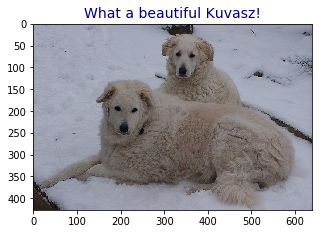

In [38]:
run_app(dog_files[3000])

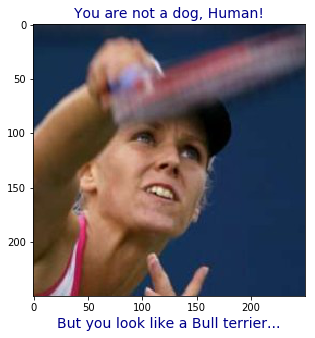

In [39]:
run_app(human_files[200])

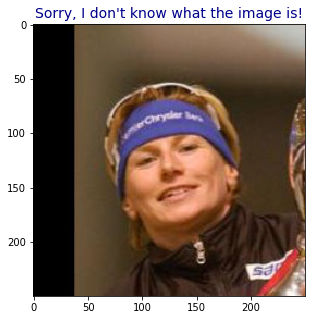

In [40]:
run_app(human_files[900])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__

The output was actually much batter than I expected :). In fact, the transfer learning model reached such a good accuracy that it is hard to find a missclassified image.

Some points of improvement are the following:

1) The human face detector classifier is not that good. As we can see above, it fails to detect some images, specially if the image contains some "defect" on it. A binary classification model would probably do a better job. In this case, a good idea would be to consider three classes: dog, human and others. We could then replace the dog_detector and face_detector algorithms by a single one.

2) Although an accuracy of 84% was achieved with the transfer learning algorithm, one can notice that the validation loss was still decreasing. Moreover, as was mentioned before, resnet have available deeper network versions. Therefore, better results could definetly be obtained, at the cost of more execution time. In fact, if we simply run the same algorithm for more epochs, a higher accuracy would already be achieved.

3) Classifying dog breeds is a typical imbalanced problem, since there are breeds more common than others and, therefore, the breeds frequency have a tailed distribution. This kind of problem is receiving much attention and techniques such as semi-supervised and self-supervised learning have been used to improve model performance. For this type of problem, the accuracy can be misleading, and better results can be achieved in terms of confusion matrix. Example of research: https://arxiv.org/abs/2006.07529

4) The app itself could be improved converting it into an API using something like Flask, which is something that I definetly will be doing in the future.

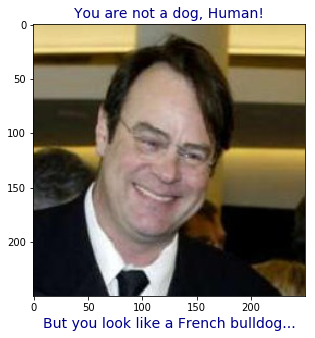

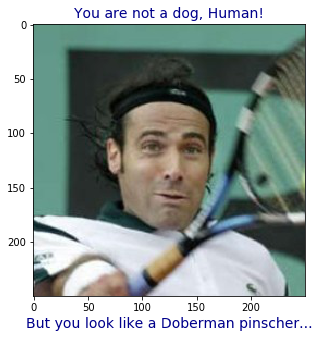

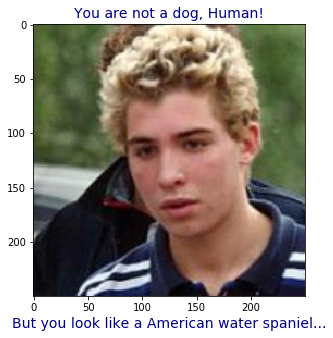

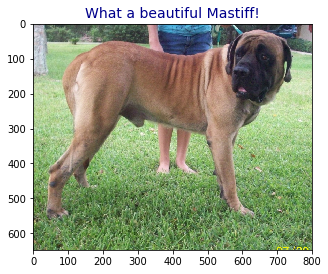

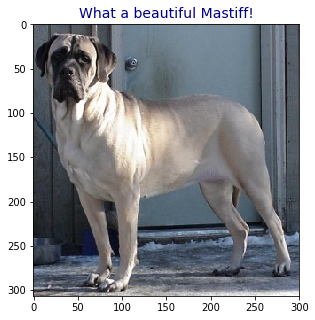

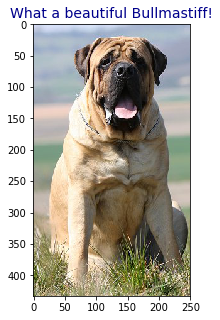

In [41]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)